In [2]:
import tensorflow as tf

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, GRU, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import pickle
import re

In [5]:
# --- Configuration ---
DATA_DIR = "D:/M.Tech_all_project_code/M.Tech_all_project_code/dataset/training_small_dataset/small_dataset"
TRAIN_FILE = os.path.join(DATA_DIR, "train.txt")
VAL_FILE = os.path.join(DATA_DIR, "val.txt")
TEST_FILE = os.path.join(DATA_DIR, "test.txt")
MODEL_SAVE_PATH = "D:/model/crnn_phishing_model.keras"
TOKENIZER_SAVE_PATH = "D:/model/tokenizer.pkl"

MAX_LEN = 200  # Maximum length of URL sequence
EMBEDDING_DIM = 128
VOCAB_SIZE = None # Will be determined from data
BATCH_SIZE = 128
EPOCHS = 10 # Adjust as needed, EarlyStopping will find the best

In [6]:
# --- Data Loading and Preprocessing ---
def load_data(file_path):
    """Loads URLs and labels from a text file."""
    urls = []
    labels = []
    print(f"Loading data from: {file_path}")
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t', 1)
                if len(parts) == 2:
                    label, url = parts
                    # Basic cleaning: lowercase
                    url = url.lower()
                    # Replace multiple consecutive non-alphanumeric chars with a single one (optional)
                    # url = re.sub(r'[^a-z0-9]+', '', url) # Example more aggressive cleaning
                    labels.append(1 if label == "phishing" else 0)
                    urls.append(url)
                else:
                    print(f"Skipping malformed line: {line.strip()}")
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None, None
    print(f"Loaded {len(urls)} samples.")
    return urls, np.array(labels)

def create_tokenizer(texts):
    """Creates and fits a character-level tokenizer."""
    # Use all unique characters
    chars = set()
    for text in texts:
        chars.update(text)
    
    char_index = {char: i + 1 for i, char in enumerate(sorted(list(chars)))} # Reserve 0 for padding
    index_char = {i: char for char, i in char_index.items()}
    vocab_size = len(char_index) + 1 # Add 1 for padding
    print(f"Vocabulary size: {vocab_size}")
    return char_index, index_char, vocab_size

def texts_to_sequences(texts, char_index):
    """Converts texts to sequences of indices."""
    return [[char_index.get(char, 0) for char in text] for text in texts] # Use 0 if char not in index (shouldn't happen with fit)

print("--- Starting Data Loading and Preprocessing ---")


--- Starting Data Loading and Preprocessing ---


In [7]:
# Load data
train_urls, train_labels = load_data(TRAIN_FILE)
val_urls, val_labels = load_data(VAL_FILE)

if train_urls is None or val_urls is None:
    print("Failed to load data. Exiting.")
    exit()

# Create and fit tokenizer on training data only
char_index, index_char, VOCAB_SIZE = create_tokenizer(train_urls)

# Save tokenizer
print(f"Saving tokenizer to {TOKENIZER_SAVE_PATH}")
with open(TOKENIZER_SAVE_PATH, 'wb') as handle:
    pickle.dump({'char_index': char_index, 'index_char': index_char, 'vocab_size': VOCAB_SIZE, 'max_len': MAX_LEN}, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Convert texts to sequences
train_sequences = texts_to_sequences(train_urls, char_index)
val_sequences = texts_to_sequences(val_urls, char_index)

# Pad sequences
print(f"Padding sequences to max length: {MAX_LEN}")
train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Training data shape: {train_padded.shape}")
print(f"Validation data shape: {val_padded.shape}")

Loading data from: D:/M.Tech_all_project_code/M.Tech_all_project_code/dataset/training_small_dataset/small_dataset\train.txt
Loaded 364199 samples.
Loading data from: D:/M.Tech_all_project_code/M.Tech_all_project_code/dataset/training_small_dataset/small_dataset\val.txt
Loaded 104576 samples.
Vocabulary size: 71
Saving tokenizer to D:/model/tokenizer.pkl
Padding sequences to max length: 200
Training data shape: (364199, 200)
Validation data shape: (104576, 200)


In [8]:
# Create tf.data datasets for efficiency
train_dataset = tf.data.Dataset.from_tensor_slices((train_padded, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_padded, val_labels))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("--- Data Loading and Preprocessing Complete ---")

--- Data Loading and Preprocessing Complete ---


In [9]:
# --- Model Definition ---
def build_crnn_model(vocab_size, embedding_dim, max_len):
    """Builds the CRNN model."""
    print("--- Building CRNN Model ---")
    input_layer = Input(shape=(max_len,), name='input_layer')
    
    # Embedding Layer
    embedding_layer = Embedding(input_dim=vocab_size, 
                                output_dim=embedding_dim, 
                                input_length=max_len, 
                                name='embedding_layer')(input_layer)
    
    # Convolutional Layers
    conv1 = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', name='conv1d_1')(embedding_layer)
    pool1 = MaxPooling1D(pool_size=2, name='maxpool1d_1')(conv1)


    conv2 = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', name='conv1d_2')(pool1) # Using pool1 output
    pool2 = MaxPooling1D(pool_size=2, name='maxpool1d_2')(conv2)


    # Recurrent Layers (LSTM or GRU)
    # Using GRU as they are often faster with similar performance to LSTM
    rnn_layer = Bidirectional(GRU(128, return_sequences=False), name='bidirectional_gru')(pool2) # return_sequences=False if not followed by another RNN or Attention
    # Or use LSTM: rnn_layer = Bidirectional(LSTM(128, return_sequences=False), name='bidirectional_lstm')(pool2)
    
    drop_rnn = Dropout(0.5, name='dropout_rnn')(rnn_layer) # Dropout after RNN

    # Dense Layers
    dense1 = Dense(64, activation='relu', name='dense_1')(drop_rnn)
    drop_dense = Dropout(0.5, name='dropout_dense')(dense1)
    output_layer = Dense(1, activation='sigmoid', name='output_layer')(drop_dense)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile Model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(name='precision'), 
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(name='auc')])
    
    print("--- Model Built Successfully ---")
    return model

model = build_crnn_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN)
model.summary()

--- Building CRNN Model ---
--- Model Built Successfully ---
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200)]             0         
                                                                 
 embedding_layer (Embedding)  (None, 200, 128)         9088      
                                                                 
 conv1d_1 (Conv1D)           (None, 200, 128)          82048     
                                                                 
 maxpool1d_1 (MaxPooling1D)  (None, 100, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 128)          82048     
                                                                 
 maxpool1d_2 (MaxPooling1D)  (None, 50, 128)           0         
                                                                 


In [10]:
# --- Training ---
print("--- Starting Model Training ---")

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', # Monitor validation loss
                               patience=3,        # Stop after 3 epochs of no improvement
                               verbose=1,
                               restore_best_weights=True) # Restore the best weights found

model_checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, 
                                 monitor='val_loss', # Save based on validation loss
                                 save_best_only=True, 
                                 verbose=1)

history = model.fit(train_dataset, 
                    epochs=EPOCHS, 
                    validation_data=val_dataset, 
                    callbacks=[early_stopping, model_checkpoint])

print("--- Model Training Complete ---")
print(f"Best model saved to: {MODEL_SAVE_PATH}")

--- Starting Model Training ---
Epoch 1/10
2846/2846 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9526 - precision: 0.9472 - recall: 0.9465 - auc: 0.9913
Epoch 1: val_loss improved from inf to 0.07453, saving model to D:/model\crnn_phishing_model.keras
2846/2846 [==============================] - 99s 30ms/step - loss: 0.1161 - accuracy: 0.9526 - precision: 0.9472 - recall: 0.9465 - auc: 0.9913 - val_loss: 0.0745 - val_accuracy: 0.9712 - val_precision: 0.9578 - val_recall: 0.9786 - val_auc: 0.9967
Epoch 2/10
2845/2846 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9742 - precision: 0.9732 - recall: 0.9687 - auc: 0.9966
Epoch 2: val_loss improved from 0.07453 to 0.06280, saving model to D:/model\crnn_phishing_model.keras
2846/2846 [==============================] - 82s 29ms/step - loss: 0.0680 - accuracy: 0.9742 - precision: 0.9732 - recall: 0.9687 - auc: 0.9966 - val_loss: 0.0628 - val_accuracy: 0.9753 - val_precision: 0.9827 - val_rec

In [11]:
loss, accuracy, precision, recall, auc = model.evaluate(val_dataset, verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation AUC: {auc:.4f}")

817/817 [==============================] - 11s 13ms/step - loss: 0.0554 - accuracy: 0.9785 - precision: 0.9806 - recall: 0.9711 - auc: 0.9975
Validation Loss: 0.0554
Validation Accuracy: 0.9785
Validation Precision: 0.9806
Validation Recall: 0.9711
Validation AUC: 0.9975


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
# Further analysis (optional)
val_pred_probs = model.predict(val_dataset)
val_pred_labels = (val_pred_probs > 0.5).astype(int)
print("\nValidation Classification Report:")
print(classification_report(val_labels, val_pred_labels, target_names=['Legitimate', 'Phishing']))
print("\nValidation Confusion Matrix:")
print(confusion_matrix(val_labels, val_pred_labels))

817/817 [==============================] - 10s 11ms/step

Validation Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.98      0.98      0.98     57927
    Phishing       0.98      0.97      0.98     46649

    accuracy                           0.98    104576
   macro avg       0.98      0.98      0.98    104576
weighted avg       0.98      0.98      0.98    104576


Validation Confusion Matrix:
[[57030   897]
 [ 1348 45301]]


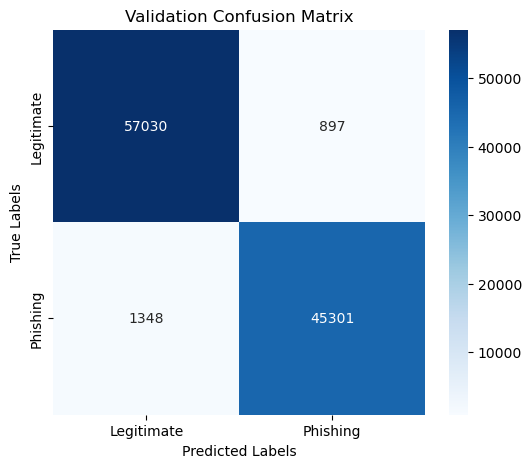

In [17]:
cm = confusion_matrix(val_labels, val_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Validation Confusion Matrix')
plt.show()

In [20]:
import tensorflow as tf

# Load the Keras SavedModel
model = tf.keras.models.load_model("D:/model/crnn_phishing_model.keras")

In [21]:
# Create converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Use Select TF Ops to allow unsupported operations
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,    # Default TFLite ops
    tf.lite.OpsSet.SELECT_TF_OPS       # Enable TF ops not in TFLite
]

# Disable experimental lowering of tensor list ops
converter._experimental_lower_tensor_list_ops = False

# Optional: optimize for size/speed
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert
tflite_model = converter.convert()

# Save TFLite model
with open("model_select_tf_ops.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model with SELECT_TF_OPS saved.")


INFO:tensorflow:Assets written to: C:\Users\manis\AppData\Local\Temp\tmpg5_j5abd\assets


INFO:tensorflow:Assets written to: C:\Users\manis\AppData\Local\Temp\tmpg5_j5abd\assets


TFLite model with SELECT_TF_OPS saved.
